# Pick Data

### Environment setup

In [125]:
import acquire
import prepare
import wrangle_pick
import summarize
import explore
import model

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression
from sklearn.metrics import median_absolute_error
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates #to format dates on our plots

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

# Wrangle

In [2]:
train, validate, test= wrangle_pick.wrangle_pick_data()
train.shape, validate.shape, test.shape

Acquire: downloading raw data files...
Acquire: Completed!
Prepare: Cleaning acquired data...
Prepare: Completed!


((96634, 16), (17054, 16), (20063, 16))

In [3]:
train.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [4]:
# found that Xy function was changing original train, validate, test
# try creating copies first so that original are uneffected
X_train = train.copy()
X_validate = validate.copy()
X_test = test.copy()

In [5]:
# exploration of train shows 2% of orders are more than 1 box, dropping these to reduce noise for mvp
X_train_exp, X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle_pick.createXy(X_train, X_validate, X_test)

X_train_exp.shape, X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((94461, 16),
 (94461, 15),
 (16693, 15),
 (19588, 15),
 (94461, 1),
 (16693, 1),
 (19588, 1))

In [6]:
train.shape, X_train_exp.shape, X_train.shape

((96634, 16), (94461, 16), (94461, 15))

In [7]:
# create df for explore where orders with more than 1 box are included
exp = train.copy()

In [8]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96634 entries, 83105 to 136055
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   operator       96634 non-null  object         
 1   total_lines    96634 non-null  int64          
 2   total_boxes    96634 non-null  int64          
 3   start          96634 non-null  datetime64[ns] 
 4   end            96634 non-null  datetime64[ns] 
 5   pick_time      96634 non-null  timedelta64[ns]
 6   pick_seconds   96634 non-null  int64          
 7   day            96634 non-null  int64          
 8   day_name       96634 non-null  object         
 9   year           96634 non-null  int64          
 10  month          96634 non-null  int64          
 11  week           96634 non-null  int64          
 12  hour           96634 non-null  int64          
 13  sec_per_box    96634 non-null  float64        
 14  lines_per_box  96634 non-null  float64        
 1

In [9]:
# create df for time series exploration includes orders with more than 1 box
ts = train.copy()

# Non-TS index Explore

## Prep explore dataframe

In [10]:
exp1 = exp[['total_lines', 'total_boxes', 'pick_seconds', 'operator', 'hour', 'day', 'day_name', 
            'week', 'month', 'year', 'sec_per_box', 'lines_per_box', 'sec_per_line' ]]

In [11]:
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


In [12]:
exp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96634 entries, 83105 to 136055
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_lines    96634 non-null  int64  
 1   total_boxes    96634 non-null  int64  
 2   pick_seconds   96634 non-null  int64  
 3   operator       96634 non-null  object 
 4   hour           96634 non-null  int64  
 5   day            96634 non-null  int64  
 6   day_name       96634 non-null  object 
 7   week           96634 non-null  int64  
 8   month          96634 non-null  int64  
 9   year           96634 non-null  int64  
 10  sec_per_box    96634 non-null  float64
 11  lines_per_box  96634 non-null  float64
 12  sec_per_line   96634 non-null  float64
dtypes: float64(3), int64(8), object(2)
memory usage: 10.3+ MB


In [13]:
# export this dataframe for exploring in Tableau
exp1.to_csv('exp1.csv')

In [14]:
exp1 = pd.read_csv('exp1.csv', index_col=0)
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


### check for observations where pick_seconds is 0

- none where seconds is 0, 1, or 2 only 3 records where time is 4 seconds

Checking to make sure orders have a minimum time greater than 2 seconds.

In [15]:
exp1[exp1.pick_seconds==3]

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
77421,2,1,3,HB,11,8,Saturday,14,4,2017,3.0,2.0,1.5
78873,2,1,3,IT,13,18,Friday,33,8,2017,3.0,2.0,1.5
25102,2,1,3,DACE,13,29,Friday,4,1,2016,3.0,2.0,1.5
81015,2,1,3,HB,13,9,Thursday,45,11,2017,3.0,2.0,1.5


## create visualizations

**DEFINITIONS**     
- each observation is 1 order to fulfill
- the number of lines is the number of (unique?) items to put in the box
- each order is a minimum of 1 box, though more boxes may be needed
    - check if lines are higher on multiple box orders
    - compare mean pick times for multiple box orders

In [16]:
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


In [17]:
exp1.groupby(['total_boxes']).total_lines.agg(['mean', 'median', 'count'])

,mean,median,count
total_boxes,,,
1,7.949439,4.0,94461
2,12.043898,6.0,1139
3,7.940850,5.0,541
4,6.888235,6.0,170
5,6.793103,6.0,116
6,9.654545,5.0,55
7,7.318182,8.5,22
8,6.772727,5.0,22
9,7.333333,7.0,15


In [18]:
# what is the avg lines for orders with more than 1 box?
avg2plusbox = exp1[exp1.total_boxes >1].total_lines.agg(['mean', 'count'])
# what is the avg line for orders with 1 box?
avg1box = exp1[exp1.total_boxes == 1].total_lines.agg(['mean', 'count'])
# what is the population average?
popavg = exp1.total_lines.agg(['mean', 'count'])
print('average total_lines=', popavg)
print('average lines for orders with 1 box=', avg1box)
print('average lines for orders with 2 or more boxes=', avg2plusbox)

average total_lines= mean         7.993429
count    96634.000000
Name: total_lines, dtype: float64
average lines for orders with 1 box= mean         7.949439
count    94461.000000
Name: total_lines, dtype: float64
average lines for orders with 2 or more boxes= mean        9.90566
count    2173.00000
Name: total_lines, dtype: float64


- there are, relatively, very few orders with more than 1 box (only 2K out of 96K)
- might want to drop observations with more than 1 box for MVP model to reduce noise
- due to the imbalance of data the overall average and 1 box average are nearly the same

### Hypothesis Test 1

Is the variance between the average number of lines for the orders with more than 1 box significantly different from the population average?

Ho: The difference is not significant     
Ha: There is a significant difference between the average number of lines      
alpha = .05 (meaning there 95% confidence variation is not due to random chance)     

The p is less than alpha so the null hypothesis (Ho) is rejected

In [19]:
# use one sample t-test
over1box = exp1[exp1.total_boxes >1].total_lines
popmean = exp1.total_lines.mean()
t, p = explore.ttest_1samp(over1box, popmean)

t= 5.705542127216953
p= 1.3182503622016165e-08
p is less than alpha= True


In [20]:
exp1.groupby(['total_boxes']).pick_seconds.agg(['mean', 'median', 'count'])

,mean,median,count
total_boxes,,,
1,143.845481,75.0,94461
2,354.193152,209.0,1139
3,275.896488,175.0,541
4,234.317647,187.5,170
5,212.965517,181.0,116
6,340.545455,233.0,55
7,269.454545,244.0,22
8,266.272727,219.0,22
9,341.066667,225.0,15


In [21]:
# what is the avg pick time for orders with more than 1 box?
pickavg2plusbox = exp1[exp1.total_boxes >1].pick_seconds.agg(['mean', 'median', 'count'])
# what is the avg pick time for orders with 1 box?
pickavg1box = exp1[exp1.total_boxes == 1].pick_seconds.agg(['mean', 'median', 'count'])
# what is the average pick time?
pickpopavg = exp1.pick_seconds.agg(['mean', 'median', 'count'])
print('average total_lines=')
print(pickpopavg)
print('average lines for orders with 1 box=')
print(pickavg1box)
print('average lines for orders with 2 or more boxes=')
print(pickavg2plusbox)

average total_lines=
mean        147.583149
median       77.000000
count     96634.000000
Name: pick_seconds, dtype: float64
average lines for orders with 1 box=
mean        143.845481
median       75.000000
count     94461.000000
Name: pick_seconds, dtype: float64
average lines for orders with 2 or more boxes=
mean       310.060746
median     195.000000
count     2173.000000
Name: pick_seconds, dtype: float64


### Hypothesis Test 2

Is the variance between the average pick seconds for the orders with more than 1 box significantly different from the population average?

Ho: The difference is not significant     
Ha: There is a significant difference between the average pick seconds for orders with more than 1 box      
alpha = .05 (meaning there 95% confidence variation is not due to random chance)     

The p is less than alpha so the null hypothesis (Ho) is rejected

In [22]:
# use one sample t-test
pover1box = exp1[exp1.total_boxes >1].pick_seconds
ppopmean = exp1.pick_seconds.mean()
t, p = explore.ttest_1samp(pover1box, ppopmean)

t= 18.07771844491187
p= 3.68542433327383e-68
p is less than alpha= True


## Explore variation in pick seconds

- each row is an order, so the pick seconds is per order
- maximum outlier is 8000 seconds, or about 2.2 hours
- plot have y axis limit set to 2000 or about 30 min to reduce the visual impact of the outliers

### does the pick seconds vary by hour of day?
- operating hours start at 7a and end at 6p
- lots of outliers
- not much variation until last hour of day
- pattern is the same with only 1 box orders

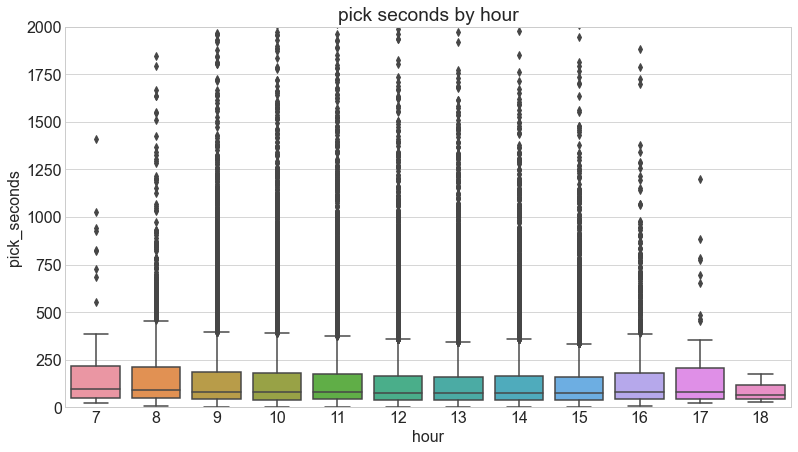

In [23]:
sns.boxplot(data=exp1, y='pick_seconds', x='hour')
plt.title('pick seconds by hour')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

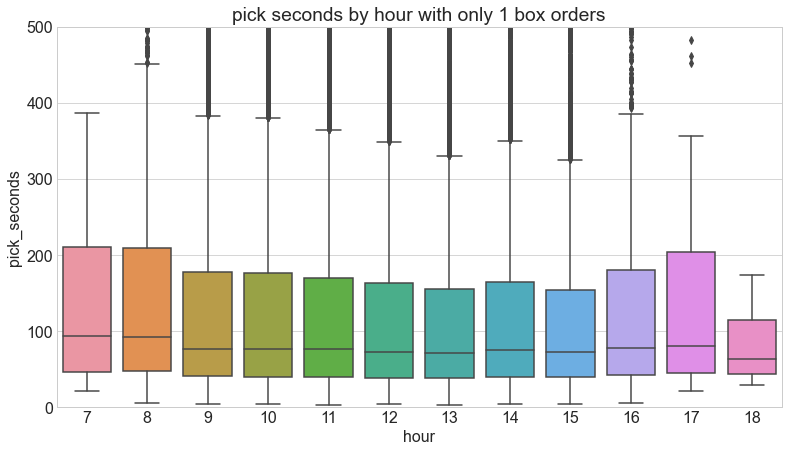

In [24]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='hour')
plt.title('pick seconds by hour with only 1 box orders')
plt.ylim(0, 500)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by day of week?
- not much on average, but there seem to be a lot of outliers?
- pattern is the same with only 1 box orders

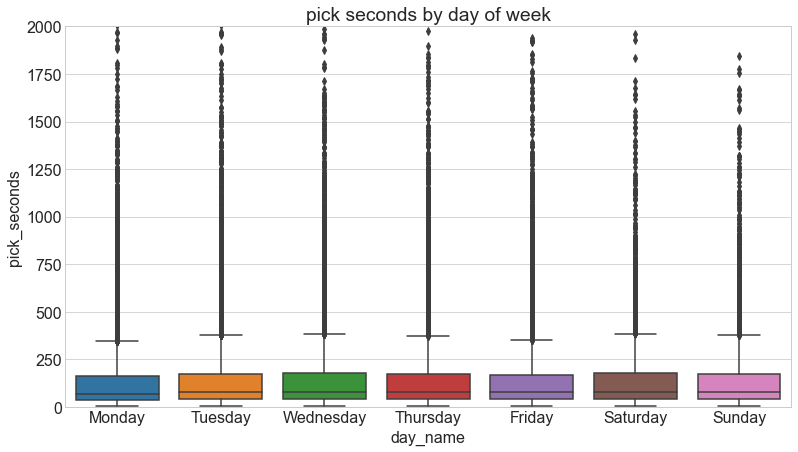

In [25]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='pick_seconds', x='day_name', order=order)
plt.title('pick seconds by day of week')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

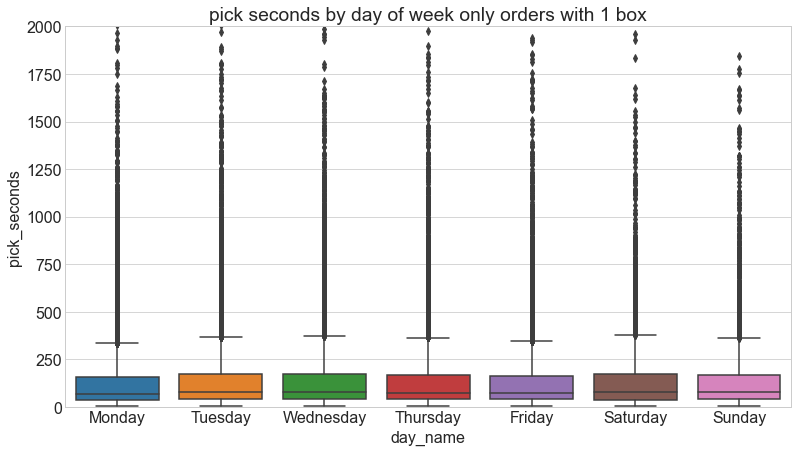

In [26]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=X_train_exp, y='pick_seconds', x='day_name', order=order)
plt.title('pick seconds by day of week only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by day of month?
- no real pattern of variation by day of month
- same with only 1 box orders

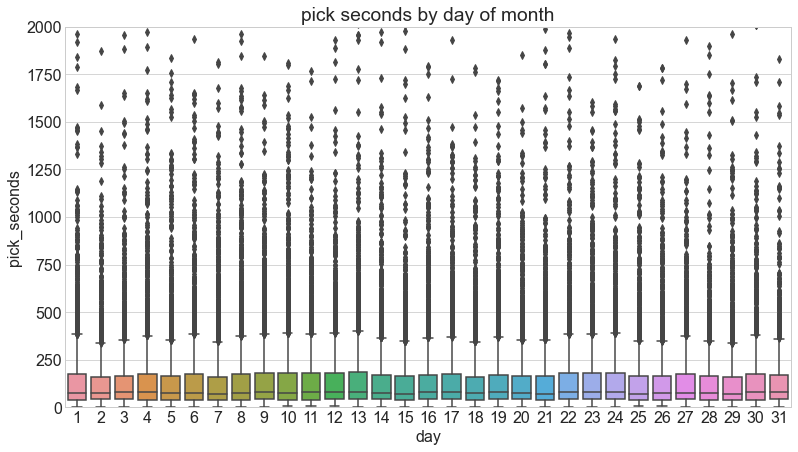

In [27]:
sns.boxplot(data=exp1, y='pick_seconds', x='day')
plt.title('pick seconds by day of month')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

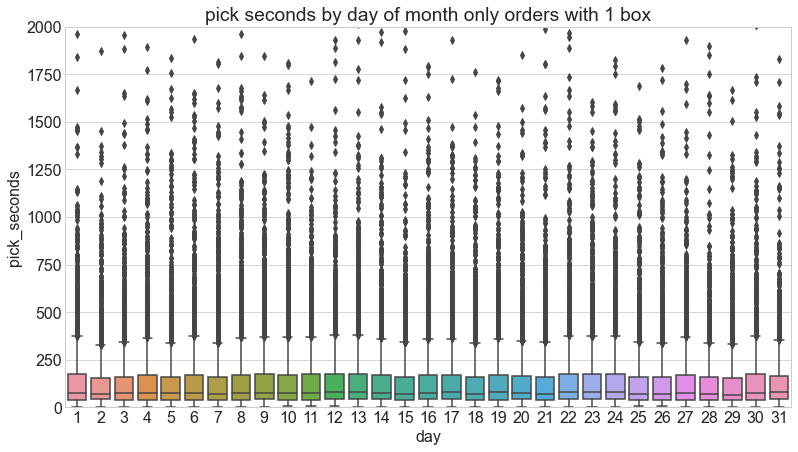

In [28]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='day')
plt.title('pick seconds by day of month only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does do the pick seconds vary by week of year?
- some variation possibly due to complexity of order variation?
- not enough of a consistent patter to use as model feature
- minimal change with only 1 box orders

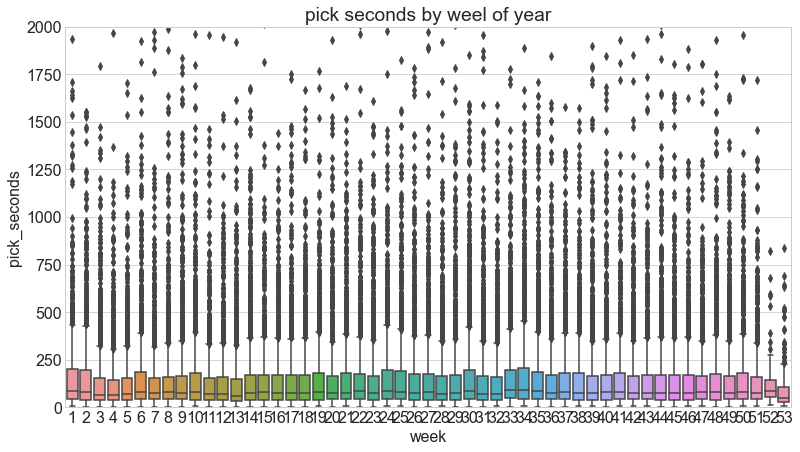

In [29]:
sns.boxplot(data=exp1, y='pick_seconds', x='week')
plt.title('pick seconds by weel of year')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

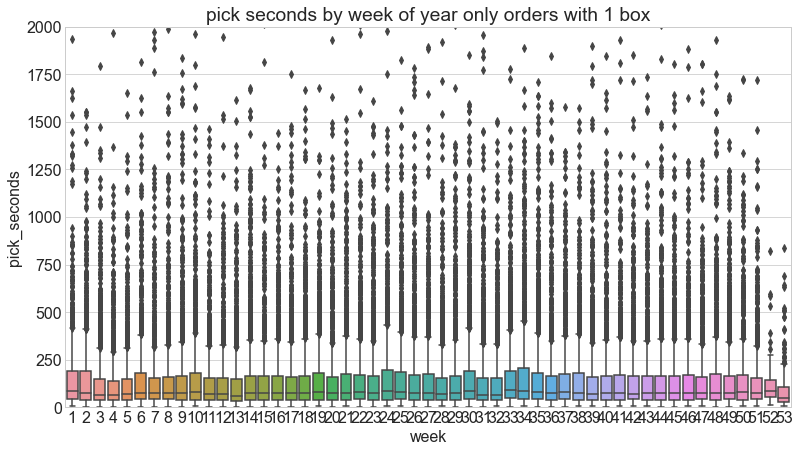

In [30]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='week')
plt.title('pick seconds by week of year only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by month of year?
- no variation by month
- no change with only 1 box orders

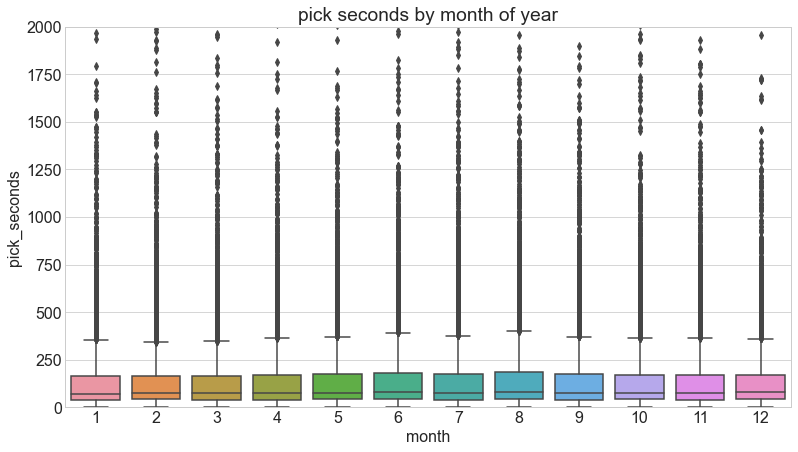

In [31]:
sns.boxplot(data=exp1, y='pick_seconds', x='month')
plt.title('pick seconds by month of year')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

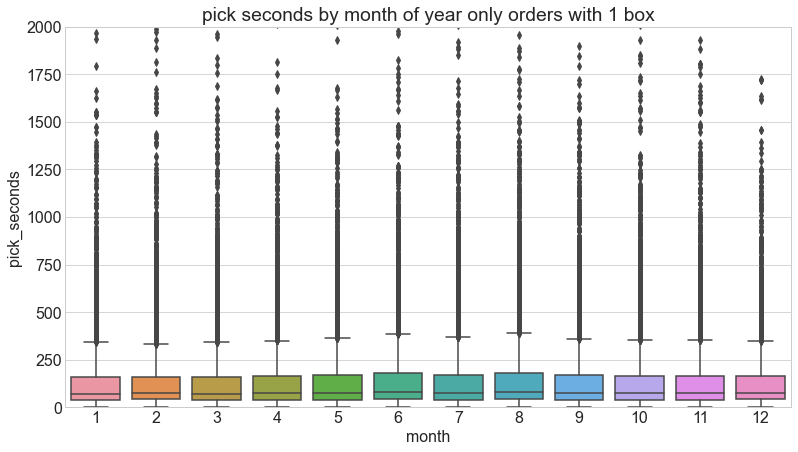

In [32]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='month')
plt.title('pick seconds by month of year only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by year?
- not really any variation by year

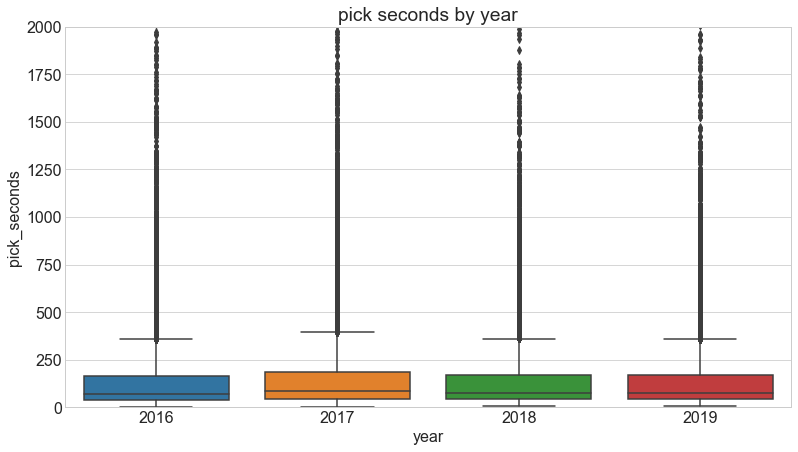

In [33]:
sns.boxplot(data=exp1, y='pick_seconds', x='year')
plt.title('pick seconds by year')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

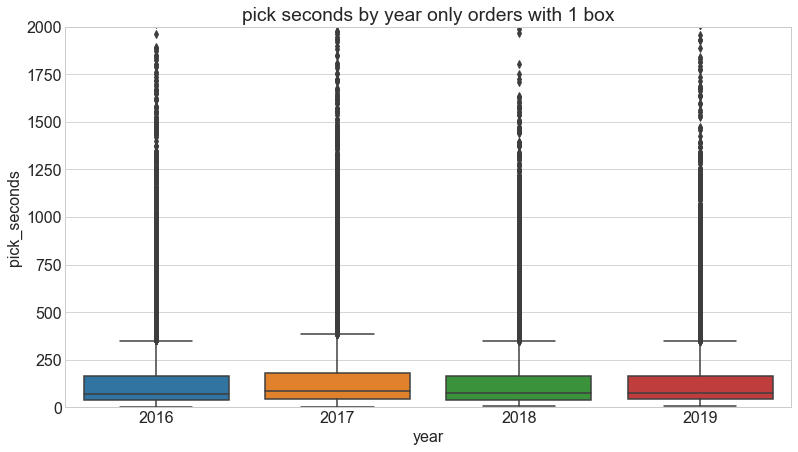

In [34]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='year')
plt.title('pick seconds by year only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

## Explore variation in total lines

This impacts the complexity of the orders

### does the total lines vary by hour of day?
- operating hours start at 7a and end at 6p
- lines are lightest at beginning and end of day with a spike around 5p
- note the y axis has been limited to 50 lines to reduce the visual impact of outliers

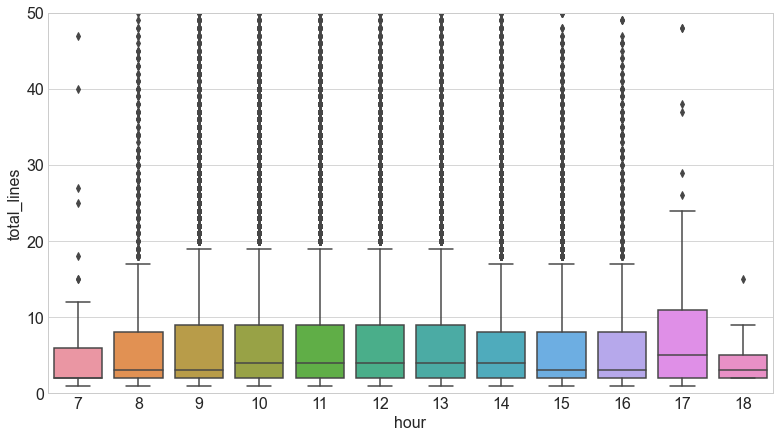

In [35]:
sns.boxplot(data=exp1, y='total_lines', x='hour')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by day of week?
- not much on average, but there seem to be a lot of outliers?

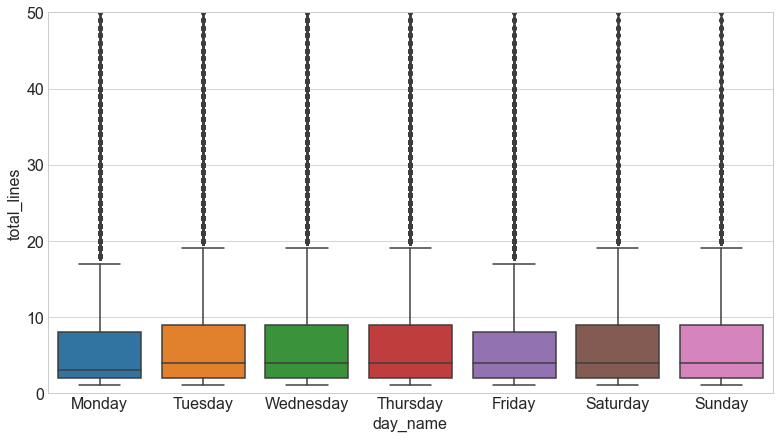

In [36]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_lines', x='day_name', order=order)
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by day of month?
- some variation on average by day of month
- first 4 days of month tend to be higher
- final days of month tend to be lower

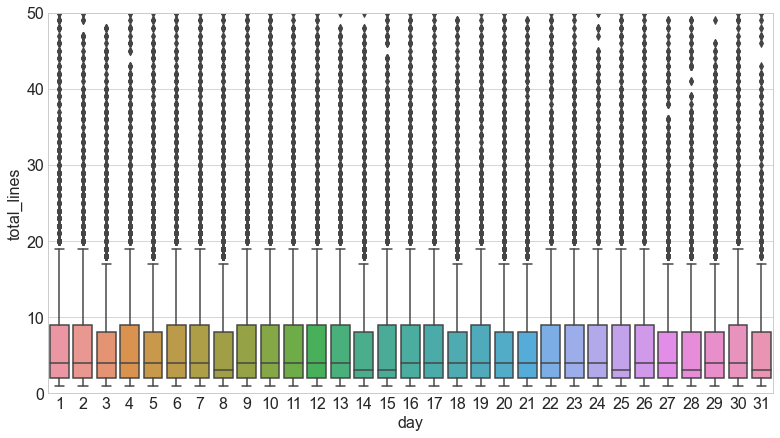

In [37]:
sns.boxplot(data=exp1, y='total_lines', x='day')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by week of year?
- Christmas and Thanksgiving weeks are lighter
- weeks at beginning of months are generally larger and weeks at end of month fewer

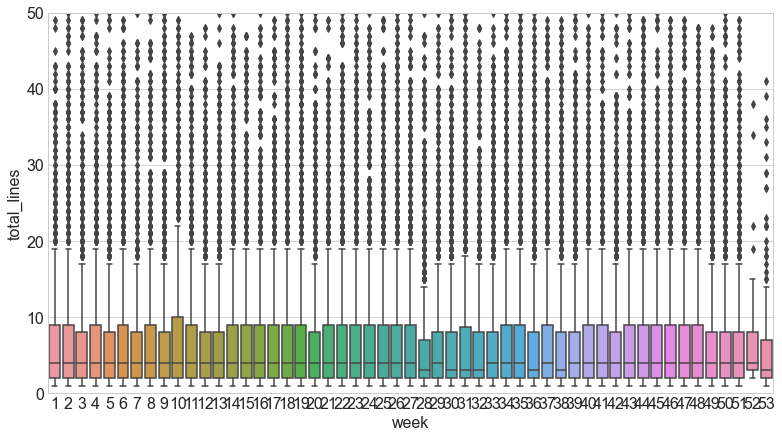

In [38]:
sns.boxplot(data=exp1, y='total_lines', x='week')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by month of year?
- not really any variation by month

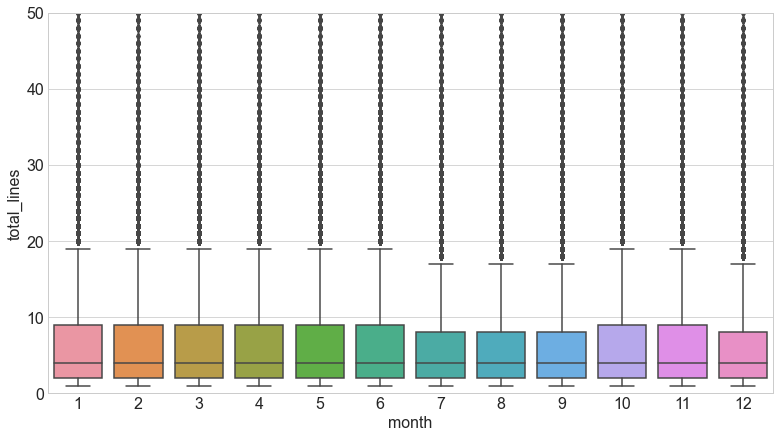

In [39]:
sns.boxplot(data=exp1, y='total_lines', x='month')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by year?
- not really any variation by year

<AxesSubplot:xlabel='year', ylabel='total_lines'>

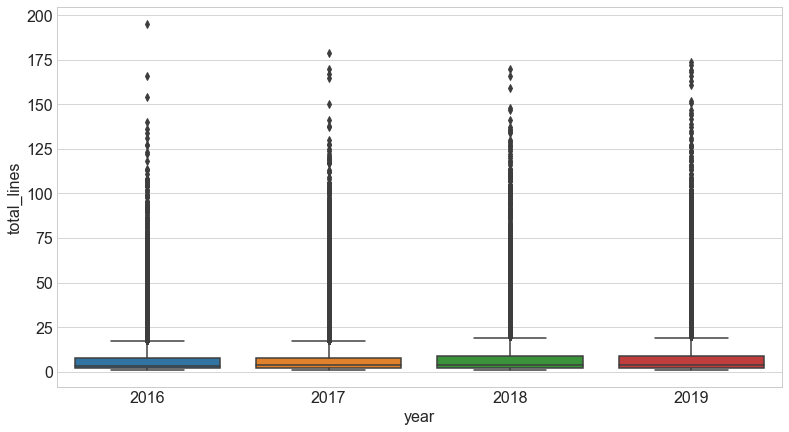

In [40]:
sns.boxplot(data=exp1, y='total_lines', x='year')

### does the total boxes vary by day of week?
- only outliers?
- typically the boxes per pick is 1 so this may not be a good feature for analysis
- might need to treat values <1 as anomalies and remove from dataset?
    - yes, picks with 0 boxes returned 7 observations that are anomalies and will be removed for this round
- visualization also shows total_boxes over 20 as anomalies
- note y axis is limited to 10 boxes

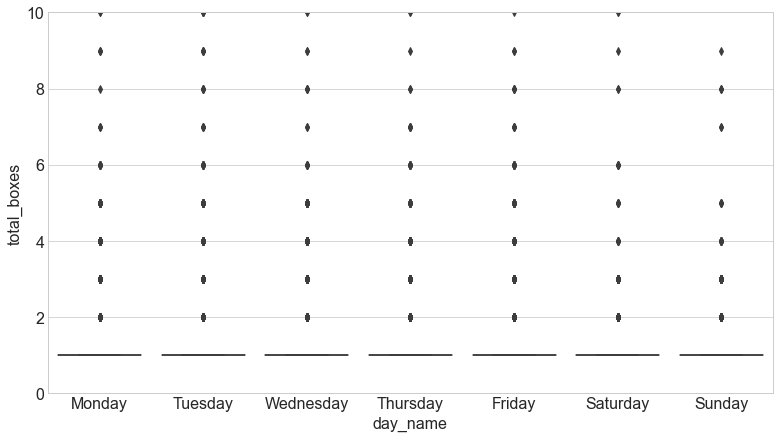

In [41]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_boxes', x='day_name', order=order)
plt.ylim(0, 10)
plt.show()
# note: y axis is limited to 10 boxes reduce visual impact of outliers

# Time Series Explore

## Prepare time series dataframe

In [42]:
ts.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [43]:
# create a dataframe with start as index and total lines, total boxes, and pick seconds as target
# these can all be aggregated by sum for resampling
pick = ts[['start', 'total_lines', 'total_boxes', 'pick_seconds']]
# set the index as start and sort for time series analysis
pick = pick.set_index('start').sort_index()

In [44]:
pick.head()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02 09:39:12,5,1,17
2016-01-02 09:42:55,2,1,22
2016-01-02 09:44:54,2,1,79
2016-01-02 09:47:42,2,1,27
2016-01-02 09:53:08,11,1,173


## Basic range and histograms

without resampling

In [45]:
pick.index.min(), pick.index.max()

(Timestamp('2016-01-02 09:39:12'), Timestamp('2019-12-24 11:08:01'))

array([[<AxesSubplot:title={'center':'total_lines'}>,
        <AxesSubplot:title={'center':'total_boxes'}>],
       [<AxesSubplot:title={'center':'pick_seconds'}>, <AxesSubplot:>]],
      dtype=object)

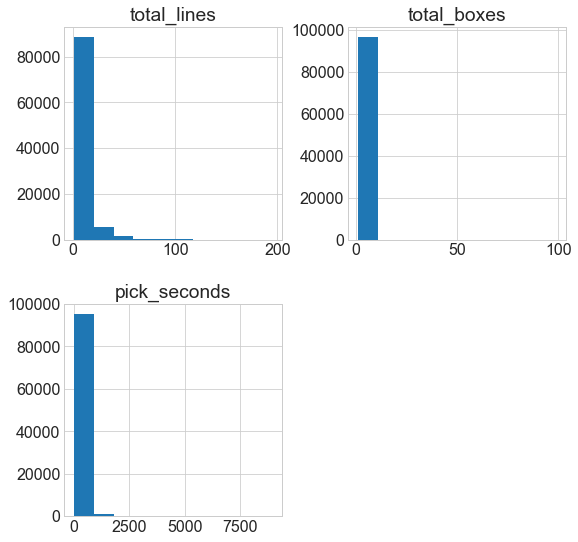

In [46]:
pick.hist(figsize=(9, 9))

<AxesSubplot:xlabel='start'>

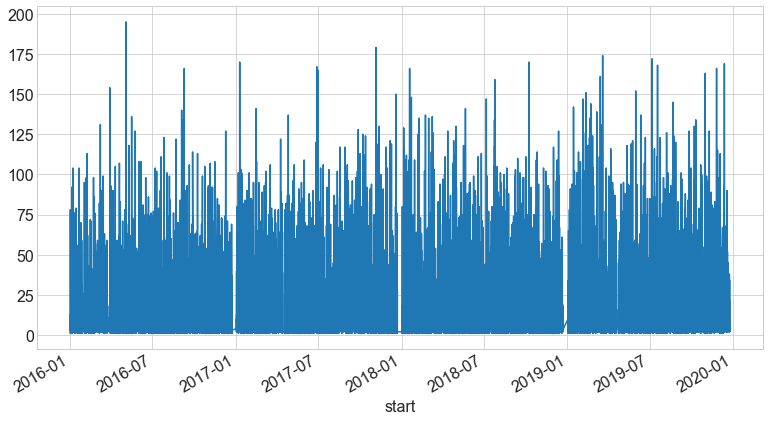

In [47]:
pick.total_lines.plot()

<AxesSubplot:xlabel='start'>

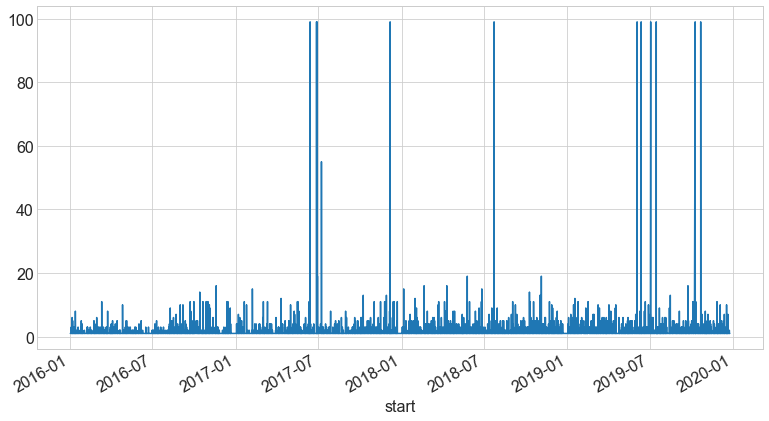

In [48]:
pick.total_boxes.plot()

<AxesSubplot:xlabel='start'>

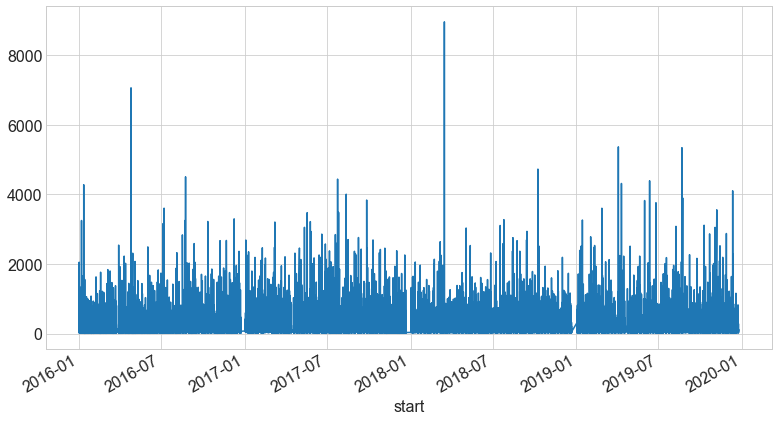

In [49]:
pick.pick_seconds.plot()

## Find anomalies in pick seconds

In [50]:
# get a df with just timeseries index and target
# for outlier dection sum by day to start (might need to do by hour if not granular enough)
pick_sec = pick[['pick_seconds']].resample('1d').sum()

In [51]:
pick_sec.head()

,pick_seconds
start,
2016-01-02,12975
2016-01-03,11130
2016-01-04,15256
2016-01-05,0
2016-01-06,11723


### Simple Moving Average

In [52]:
# get the 7 day rolling average
sma_short = pick_sec.rolling(window=7).mean()
# get the 30 day rolling average
sma_long = pick_sec.rolling(window=30).mean()

Text(0, 0.5, 'pick_sec')

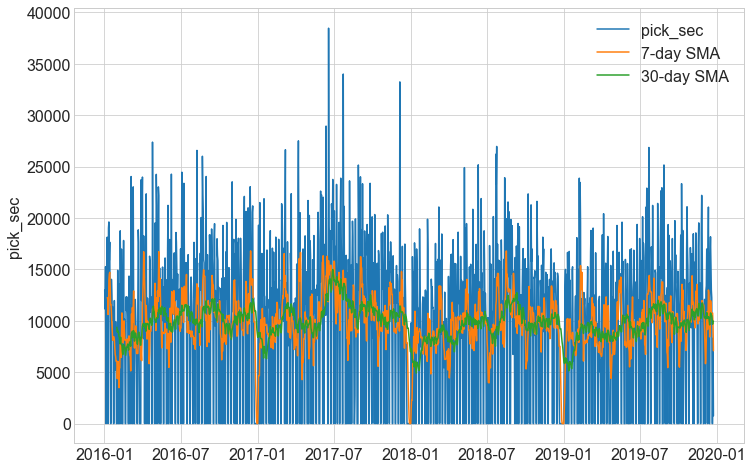

In [53]:
# plot these
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pick_sec.index, pick_sec, label='pick_sec')

ax.plot(pick_sec.index, sma_short, label = '7-day SMA')

ax.plot(pick_sec.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

### Exponential Moving Average

In [54]:
# use ewm to calculate EMA
ema_short = pick_sec.ewm(span=7).mean()
ema_long = pick_sec.ewm(span=30).mean()

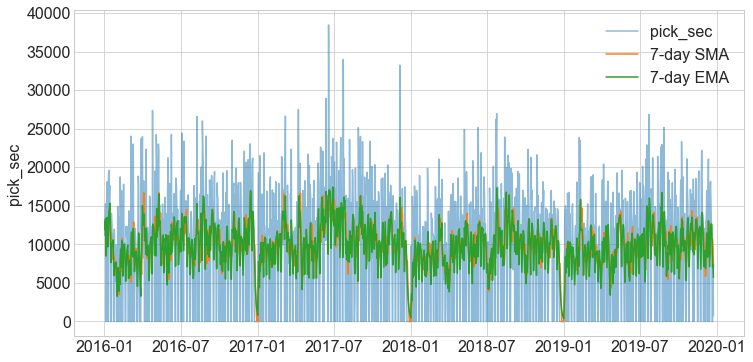

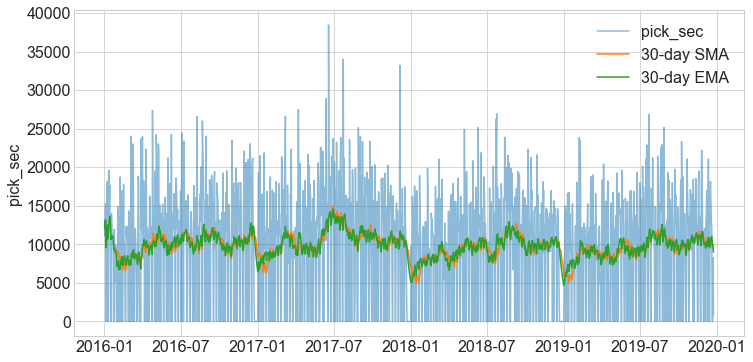

In [55]:
# plot these with SMA

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pick_sec.index, pick_sec, label='pick_sec', alpha=.5)

ax.plot(pick_sec.index, sma_short, label = '7-day SMA')
ax.plot(pick_sec.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pick_sec.index, pick_sec, label='pick_sec', alpha=.5)

ax.plot(pick_sec.index, sma_long, label = '30-day SMA')
ax.plot(pick_sec.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

plt.show()

### Bolinger bands and %b

In [56]:
# set the window span - in this case 30 days
span = 30
# compute midband
midband = pick_sec.ewm(span=span).mean()
# compute exponential stdev
stdev = pick_sec.ewm(span=span).std()
# compute upper and lower bands, multiple the midband +/- 1.5 times the standard deviation
ub = midband + stdev*1.5
lb = midband - stdev*1.5
# NOTE: lower band would actually be zero, as it is not possible to have neagtive a pick time

Text(0, 0.5, 'pick_sec')

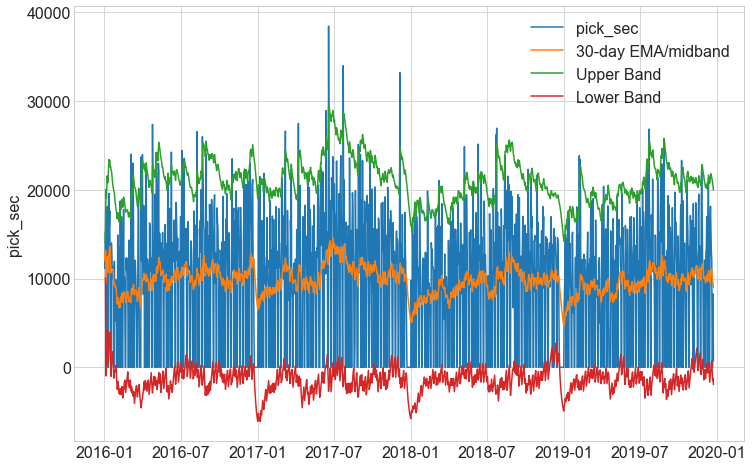

In [57]:
# plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pick_sec.index, 
        pick_sec,
        label='pick_sec')

ax.plot(pick_sec.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(pick_sec.index, 
        ub, 
        label = 'Upper Band')
ax.plot(pick_sec.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

In [58]:
# concat the dataframes together
pick_sec_sum = pd.concat([pick_sec, midband, ub, lb], axis=1)
pick_sec_sum.columns = ['pick_sec', 'midband', 'ub', 'lb']
pick_sec_sum.tail()

,pick_sec,midband,ub,lb
start,,,,
2019-12-20,12213,11044.423202,21377.301332,711.545072
2019-12-21,0,10331.879769,21149.253564,-485.494025
2019-12-22,0,9665.306881,20821.559123,-1490.945361
2019-12-23,8284,9576.190308,20378.976730,-1226.596114
2019-12-24,750,9006.758675,19966.442414,-1952.925063


In [59]:
# add a calculated column for %b
pick_sec_sum['pct_b'] = (pick_sec_sum['pick_sec'] - pick_sec_sum['lb'])/(pick_sec_sum['ub'] - pick_sec_sum['lb'])

In [60]:
# show anywhere %b is more than 1 = outside the upper band
pick_sec_sum[pick_sec_sum['pct_b']>1]

,pick_sec,midband,ub,lb,pct_b
start,,,,,
2016-02-08,18746,7559.938203,18077.734292,-2957.857886,1.031768
2016-03-05,24025,8395.667738,19464.426252,-2673.090777,1.206011
2016-03-10,23020,9292.981872,21759.921477,-3173.957733,1.050537
2016-03-29,23716,7891.369624,20353.109186,-4570.369939,1.134929
2016-04-01,23972,9913.087997,23344.148530,-3517.972535,1.023373
2016-04-25,27373,9883.440176,22653.614782,-2886.734430,1.184782
2016-05-04,24238,10666.855223,23302.787020,-1969.076575,1.037006
2016-06-09,24257,10229.857550,22835.804589,-2376.089489,1.056370
2016-07-04,24448,11304.228098,22694.283665,-85.827469,1.076985


In [61]:
# show anywhere %b is less than .1 = right at the lower band
len(pick_sec_sum[pick_sec_sum['pct_b']<.1])

270

In [62]:
pick_sec_sum[pick_sec_sum['pct_b']<.1]

,pick_sec,midband,ub,lb,pct_b
start,,,,,
2016-01-05,0,9542.979735,20055.551496,-969.592025,0.046116
2016-01-10,0,10718.483930,21038.249606,398.718254,-0.019318
2016-01-16,0,11796.952892,22657.787307,936.118476,-0.043096
2016-01-17,0,10636.717615,22286.784669,-1013.349440,0.043491
2016-01-23,0,10115.233819,20143.052963,87.414675,-0.004359
...,...,...,...,...,...
2019-12-10,0,9718.250308,20079.054175,-642.553559,0.031009
2019-12-14,0,10191.713354,21093.665049,-710.238341,0.032574
2019-12-15,0,9534.183460,20749.187114,-1680.820194,0.074936


**takeaways**
- with 3 as the multiplier there are no results outside of the bands
- changing multiplier to 1.5
- drop 274 days with a pick time of 0 sec?
    - these are Saturdays, holidays, and possibly inventory days based on dates
    - they are generated from resampling 
    
- there are 51 rows with pick times above the upper band at 1.5
    - but this is a sum of the total pick seconds per day, these may be a result of adding operators to that day?
    - would need to add %b values to df with operators and look at those specific days
    - especially given they are within range when multiplier is 3

## Resample by Hour - RETURN HERE AFTER MVP?

In [63]:
pick.resample('H').sum()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02 09:00:00,41,7,548
2016-01-02 10:00:00,132,21,2227
2016-01-02 11:00:00,212,18,3873
2016-01-02 12:00:00,115,18,1487
2016-01-02 13:00:00,196,17,3165
...,...,...,...
2019-12-24 07:00:00,0,0,0
2019-12-24 08:00:00,6,2,145
2019-12-24 09:00:00,0,0,0


In [64]:
pick.isna().sum()

total_lines     0
total_boxes     0
pick_seconds    0
dtype: int64

# Model


- prep for model??
    - drop observations where there is more than 1 box to reduce noise
    - these represent 2% of train dataset
    - YES will drop then create X, y sets then make an X scaled and keep not scaled as well
    
- need to create feature booleen columns
    - only 1 found in data = is hour 18
    
- initial model features total_lines, sec_per_line (scale both of these), and is_hour_18 (boolean)
    - all other columns dropped
    
    
Decided to use Median Absolute Error to evaluate.     
"The median_absolute_error is particularly interesting because it is robust to outliers. The loss is calculated by taking the median of all absolute differences between the target and the prediction."
https://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error

## Create Baseline

- Baseline is the mean pick_seconds per order


In [153]:
baseline = round(y_train.pick_seconds.mean(), 2)
print(f'The average pick seconds per order is', baseline)

The average pick seconds per order is 143.85


In [154]:
# Predict bps_pred_mean (baseline predicted mean)
bps_pred_mean = y_train['pick_seconds'].mean()
y_train['bps_pred_mean'] = bps_pred_mean
y_validate['bps_pred_mean'] = bps_pred_mean
y_test['bps_pred_mean'] = bps_pred_mean

In [175]:
# Median Absolute Error (MAE) recommended for non-normally distributed data
# may not matter giving the law of large numbers?

base_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.bps_pred_mean)
print("MAE using baseline Mean\nTrain/In-Sample: ", round(base_med_abs_train, 2)) 

Mean predicted pick seconds with linear regression model: 143.85
MAE using baseline Mean
Train/In-Sample:  94.85


## Preprocessing

- create and scale features
- drop unnecessary columns


In [66]:
X_train.head()

,operator,total_lines,total_boxes,start,end,pick_time,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [67]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_pick.model_preprocess1(X_train, X_validate, X_test)
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((94461, 2), (16693, 2), (19588, 2))

In [68]:
X_train_scaled.head()

,total_lines_scaled,is_hr_18
83105,0.025773,0
36339,0.010309,0
151932,0.005155,0
87290,0.005155,0
55936,0.000000,0


## Linear Regression (OLS) Model

- Ordinary Least Squares

In [156]:
# create the model object
lm = LinearRegression(normalize=True)
# no change in result if normalize is True or False

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.pick_seconds)

# predict train
y_train['ps_pred_lm'] = lm.predict(X_train_scaled)

In [171]:
lm_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_lm)
print("MAE using Mean\nTrain/In-Sample: ", round(lm_med_abs_train, 2))

Mean predicted pick seconds with linear regression model: 143.85
MAE using Mean
Train/In-Sample:  37.81


## Tweedie Regressor (GLM) Model

- Generalized Linear Model

In [158]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)
# tried power (1, 2, 3) and alpha .1 and 1; 0 and 0 provide best result

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.pick_seconds)

# predict train
y_train['ps_pred_glm'] = glm.predict(X_train_scaled)


In [172]:
glm_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_glm)
print("MAE using Mean\nTrain/In-Sample: ", round(glm_med_abs_train, 2))

Mean predicted pick seconds with tweedie regressor model: 143.85
MAE using Mean
Train/In-Sample:  37.81


## Polynomial Feature Model



In [165]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)
# tried 3, 4, 8 degrees but not much different in performance and 2 is less likely to overfit
    
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.pick_seconds)

# predict train
y_train['ps_pred_pflm2'] = lm2.predict(X_train_degree2)

In [173]:
pflm2_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_pflm2)
print("MAE using Mean\nTrain/In-Sample: ", round(pflm2_med_abs_train, 2))

Mean predicted pick seconds with polynomial feature model: 143.85
MAE using Mean
Train/In-Sample:  32.72


## Validate

Given that the OLS and GLM model performance is identical I will run the OLS and Polynomial Feature models on the validate dataset.

In [177]:
# Linear Regreesion predict validate
y_validate['ps_pred_lm'] = lm.predict(X_validate_scaled)

In [178]:
lm_med_abs_val = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_lm)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(lm_med_abs_val, 2))

MAE using Mean
Train/Out-of-Sample:  37.11


In [179]:
# Polynomial Features predict validate
# predict validate
y_validate['ps_pred_pflm2'] = lm2.predict(X_validate_degree2)

In [180]:
pflm2_med_abs_val = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_pflm2)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(pflm2_med_abs_val, 2))

MAE using Mean
Train/In-Sample:  32.69


## Test

I will run the Polynomial Feature models on the test dataset.

In [181]:
# Polynomial Features predict validate
# predict test
y_test['ps_pred_pflm2'] = lm2.predict(X_test_degree2)

In [182]:
pflm2_med_abs_test = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_pflm2)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(pflm2_med_abs_test, 2))

MAE using Mean
Train/In-Sample:  32.69


# Explore by Operator - RETURN HERE


In [70]:
train.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [71]:
train.nunique()

operator            66
total_lines        161
total_boxes         19
start            96603
end              96527
pick_time         1593
pick_seconds      1593
day                 31
day_name             7
year                 4
month               12
week                53
hour                12
sec_per_box       2345
lines_per_box      308
sec_per_line      9611
dtype: int64

In [72]:
pick_agg = pick.resample('D').agg(['sum', 'count', 'mean'])

In [73]:
# unstack column names
pick_agg.columns = [' '.join(col).strip() for col in pick_agg.columns.values]
pick_agg

,total_lines sum,total_lines count,total_lines mean,total_boxes sum,total_boxes count,total_boxes mean,pick_seconds sum,pick_seconds count,pick_seconds mean
start,,,,,,,,,
2016-01-02,806,106,7.603774,106,106,1.000000,12975,106,122.405660
2016-01-03,714,119,6.000000,119,119,1.000000,11130,119,93.529412
2016-01-04,431,76,5.671053,79,76,1.039474,15256,76,200.736842
2016-01-05,0,0,NaN,0,0,NaN,0,0,NaN
2016-01-06,671,91,7.373626,98,91,1.076923,11723,91,128.824176
...,...,...,...,...,...,...,...,...,...
2019-12-20,687,92,7.467391,109,92,1.184783,12213,92,132.750000
2019-12-21,0,0,NaN,0,0,NaN,0,0,NaN
2019-12-22,0,0,NaN,0,0,NaN,0,0,NaN


In [74]:
pick_agg = pick_agg.drop(columns=['total_lines count', 'total_boxes count'])
pick_agg = pick_agg.rename(columns={'pick_seconds count': 'order_count'})
pick_agg = pick_agg.fillna(0)
pick_agg

,total_lines sum,total_lines mean,total_boxes sum,total_boxes mean,pick_seconds sum,order_count,pick_seconds mean
start,,,,,,,
2016-01-02,806,7.603774,106,1.000000,12975,106,122.405660
2016-01-03,714,6.000000,119,1.000000,11130,119,93.529412
2016-01-04,431,5.671053,79,1.039474,15256,76,200.736842
2016-01-05,0,0.000000,0,0.000000,0,0,0.000000
2016-01-06,671,7.373626,98,1.076923,11723,91,128.824176
...,...,...,...,...,...,...,...
2019-12-20,687,7.467391,109,1.184783,12213,92,132.750000
2019-12-21,0,0.000000,0,0.000000,0,0,0.000000
2019-12-22,0,0.000000,0,0.000000,0,0,0.000000


<AxesSubplot:xlabel='start'>

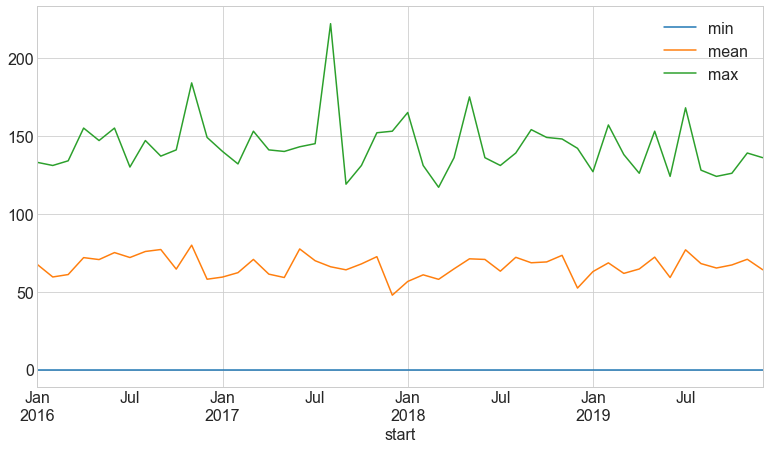

In [75]:
pick_agg.order_count.resample('M').agg(['min', 'mean', 'max']).plot()

In [76]:
train.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [77]:

# summarize web_crossover

operdf = train.groupby(['operator'])['total_lines', 'total_boxes',  'pick_seconds', 'start', 'end', 'hour'].\
                        agg({'total_lines': ['sum'], 'total_boxes' : ['sum', 'count'], 'pick_seconds': ['sum'], \
                             'start': ['min'], 'end': ['max'], 'hour': ['min', 'max']})

# use this to unstack the column names
operdf.columns = [' '.join(col).strip() for col in operdf.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

#web_crossover.groupby(['name', 'lesson'])[['sub_lesson']].count()

In [78]:
operdf

,total_lines sum,total_boxes sum,total_boxes count,pick_seconds sum,start min,end max,hour min,hour max
operator,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17
AW,53,95,18,3879,2017-07-08 08:59:00,2017-07-08 11:07:02,8,11
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16
...,...,...,...,...,...,...,...,...
TS,514,130,130,21768,2017-04-08 11:27:08,2017-09-08 09:59:23,8,16
UN3090LABE,149,21,21,2853,2017-03-11 09:10:21,2019-09-04 09:38:56,9,15
W100S/19,89,13,13,2402,2018-11-01 08:33:29,2018-11-01 10:21:26,8,10


In [79]:
operdf = operdf.rename(columns={'total_lines sum': 'total_lines', 'total_boxes sum': 'total_boxes', \
                                'total_boxes count': 'total_orders', 'pick_seconds sum': 'total_pick_sec', \
                                'start min': 'first_day', 'end max': 'last_day', 'hour min': 'shift_start_hour', \
                                'hour max': 'shift_end_hour'
                                })

In [80]:
operdf['tenure_days'] = operdf.last_day - operdf.first_day
operdf['shift_length'] = operdf.shift_end_hour - operdf.shift_start_hour
operdf.tenure_days = operdf.tenure_days.dt.days
#operdf.tenure_days = operdf.tenure_days.replace(0, 1)

In [81]:
# bin by tenure and visualize?
operdf['avg_sec_per_order'] = operdf.total_pick_sec/operdf.total_orders
operdf['avg_line_per_order'] = operdf.total_lines/operdf.total_orders
operdf['avg_box_per_order'] = operdf.total_boxes/operdf.total_orders
operdf['avg_orders_day'] = operdf.total_orders/operdf.tenure_days
operdf

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day
operator,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210
AW,53,95,18,3879,2017-07-08 08:59:00,2017-07-08 11:07:02,8,11,0,3,215.500000,2.944444,5.277778,inf
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TS,514,130,130,21768,2017-04-08 11:27:08,2017-09-08 09:59:23,8,16,152,8,167.446154,3.953846,1.000000,0.855263
UN3090LABE,149,21,21,2853,2017-03-11 09:10:21,2019-09-04 09:38:56,9,15,907,6,135.857143,7.095238,1.000000,0.023153
W100S/19,89,13,13,2402,2018-11-01 08:33:29,2018-11-01 10:21:26,8,10,0,2,184.769231,6.846154,1.000000,inf


In [82]:
operdf.tenure_days == 0

operator
AH            False
ANDREA        False
AS            False
AW             True
CB            False
              ...  
TS            False
UN3090LABE    False
W100S/19       True
W109/24        True
WH109/18       True
Name: tenure_days, Length: 66, dtype: bool

In [83]:
operdf2 = operdf.copy()

In [84]:
index = operdf2[operdf2.tenure_days == 0].index
operdf2.drop(index, inplace=True)

In [85]:
operdf2['tenure_bin'] = pd.cut(operdf2.tenure_days, bins=[0, 90, 365, 730, 1095], labels=['3m', '1yr', '2yr', '3yr'])
operdf2.tenure_bin = operdf2.tenure_bin.fillna('3m')
operdf2

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day,tenure_bin
operator,,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944,2yr
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791,1yr
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210,1yr
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926,1yr
DACE,63519,7832,7654,868773,2016-01-02 09:39:12,2016-12-08 14:53:14,8,15,341,7,113.505749,8.298798,1.023256,22.445748,1yr
DE,135,52,52,9141,2018-05-09 08:58:21,2018-09-13 15:03:45,8,14,127,6,175.788462,2.596154,1.000000,0.409449,1yr
DK,310,105,105,14524,2019-09-09 09:02:50,2019-10-09 16:57:22,9,16,30,7,138.323810,2.952381,1.000000,3.500000,3m
DP,156414,17841,16785,2215790,2017-01-08 09:12:20,2019-12-24 11:12:34,7,15,1080,8,132.010128,9.318677,1.062913,15.541667,3yr
EDITE,13374,1661,1644,194075,2016-01-02 10:01:28,2016-12-02 15:09:27,8,17,335,9,118.050487,8.135036,1.010341,4.907463,1yr


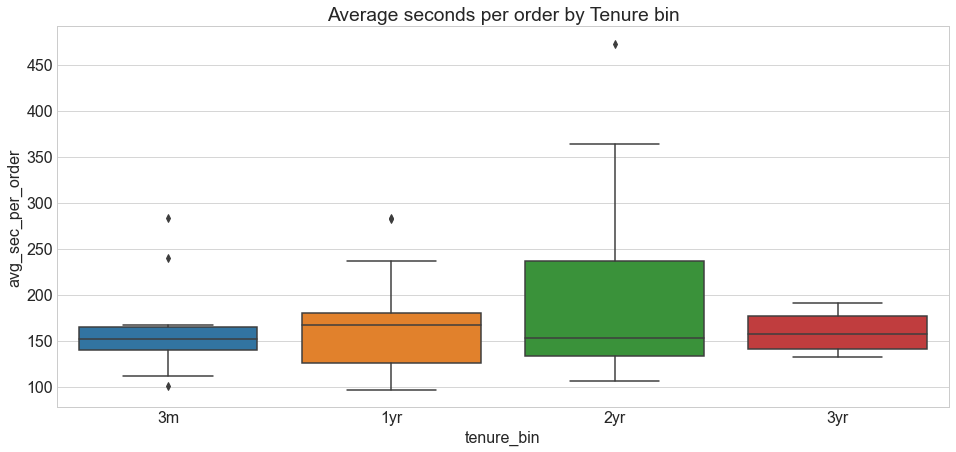

In [86]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_sec_per_order', x='tenure_bin')
plt.title('Average seconds per order by Tenure bin')
plt.show()

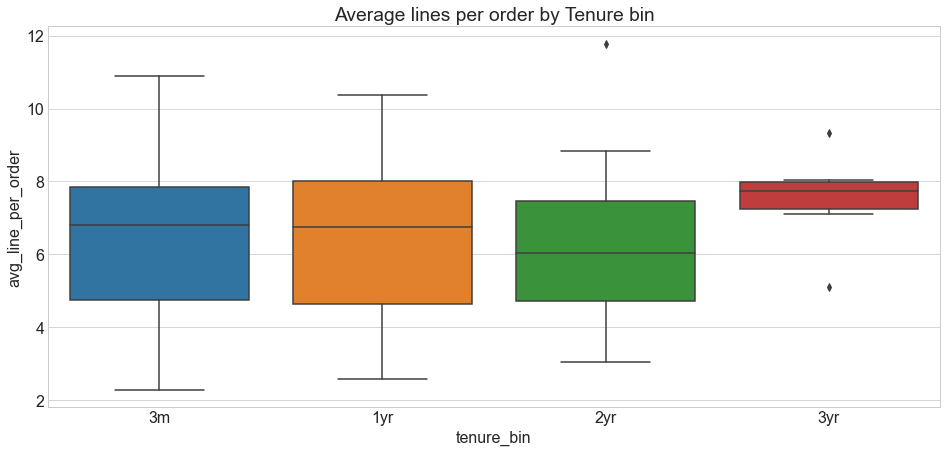

In [87]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_line_per_order', x='tenure_bin')
plt.title('Average lines per order by Tenure bin')
plt.show()

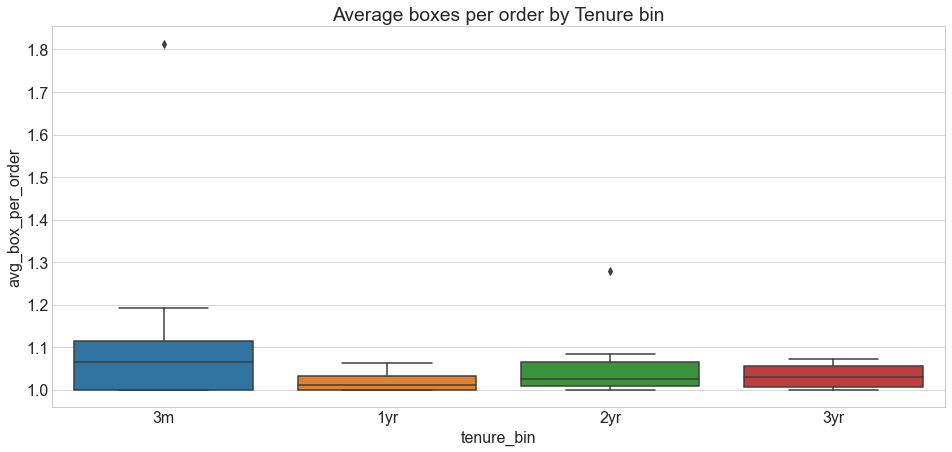

In [88]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_box_per_order', x='tenure_bin')
plt.title('Average boxes per order by Tenure bin')
plt.show()

In [89]:
operdf2

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day,tenure_bin
operator,,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944,2yr
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791,1yr
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210,1yr
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926,1yr
DACE,63519,7832,7654,868773,2016-01-02 09:39:12,2016-12-08 14:53:14,8,15,341,7,113.505749,8.298798,1.023256,22.445748,1yr
DE,135,52,52,9141,2018-05-09 08:58:21,2018-09-13 15:03:45,8,14,127,6,175.788462,2.596154,1.000000,0.409449,1yr
DK,310,105,105,14524,2019-09-09 09:02:50,2019-10-09 16:57:22,9,16,30,7,138.323810,2.952381,1.000000,3.500000,3m
DP,156414,17841,16785,2215790,2017-01-08 09:12:20,2019-12-24 11:12:34,7,15,1080,8,132.010128,9.318677,1.062913,15.541667,3yr
EDITE,13374,1661,1644,194075,2016-01-02 10:01:28,2016-12-02 15:09:27,8,17,335,9,118.050487,8.135036,1.010341,4.907463,1yr
